<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/00_books/Machine_Learning_for_Asset_Managers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Asset Managers

## Ch1

## Ch2

### Introduction

A **covariance matrix** is a squared matrix showing the covariance between each pair of variables (eg asset returns). The diagonal elements are the varainces of the single assets.

Cov matrix is essential for:
- Portfolio optimization -> allocation of weights to minimize risk or maximize returns
- Risk management -> measuring risk via variance and correlation
- ....

Which is the problem? Given a matrix

Empirical cov matrices are noisy, due to:
- Finite sample size of observations
- Imperfection of market data
- Many assets (N) and less observations (T)
This causes distortion of the true relationships

The **Marcenko-Pastur pdf** helps out!

Given a matrix X with N obesrvations and T assets with returns iid and variance σ^2, with cov matrix C = 1/T X'X then...

As N,T -> inf but q=N/T = cst then teh eigenvalues of C follow the MP pdf!

The MP distribution tells us that eigenalues λ are bounded in [λ-,λ+]

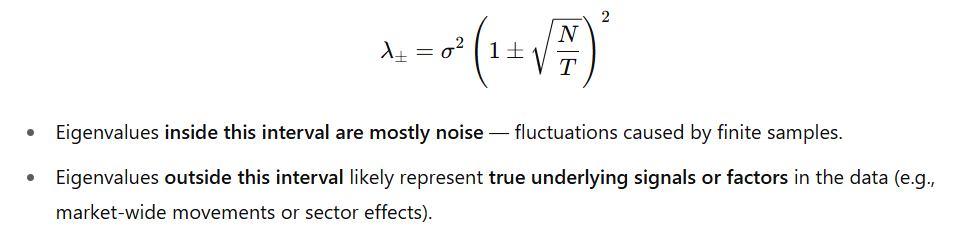

So we can:

1.  *Denoise*
- shrink (eliminate) noise eigenvalues to imporve the covariance estimate
- retain the infomrative eigenvalues
- Obtain a cleaner (denoised matrix)

2. *Detone*
- The largest λ corresponds (sometimes) to the market-wide systemic effect (common factor affecting all the assets).
- Detoning menas removing this dominant factor to analyze relationship beyond the general market movements!

In [2]:
import numpy as np, pandas as pd
#---------------------------------------------------
def mpPDF(var,q,pts):
#Marcenko-Pasturpdf
#q=T/N
  eMin,eMax=var*(1-(1./q)**.5)**2,var*(1+(1./q)**.5)**2
  eVal=np.linspace(eMin,eMax,pts)
  pdf=q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5
  pdf=pd.Series(pdf,index=eVal)
  return pdf

In [6]:
from sklearn.neighbors import KernelDensity
#---------------------------------------------------
def getPCA(matrix):
#Get eVal,eVec froma Hermitian (symmetric) matrix
  eVal,eVec=np.linalg.eigh(matrix)
  indices=eVal.argsort()[::-1]#arguments for sorting eVal desc
  eVal,eVec=eVal[indices],eVec[:,indices]
  eVal=np.diagﬂat(eVal)
  return eVal,eVec
#---------------------------------------------------
def ﬁtKDE(obs,bWidth=.25,kernel='gaussian',x=None):
#Fit kernel to a series of obs,and derive the prob of obs
#x is the array of values on which the ﬁt KDE will be evaluated
  if len(obs.shape)==1:obs=obs.reshape(-1,1)
  kde=KernelDensity(kernel=kernel,bandwidth=bWidth).ﬁt(obs)
  if x is None:x=np.unique(obs).reshape(-1,1)
  if len(x.shape)==1:x=x.reshape(-1,1)
  logProb=kde.score_samples(x)#log(density)
  pdf=pd.Series(np.exp(logProb),index=x.ﬂatten())
  return pdf
#---------------------------------------------------
x=np.random.normal(size=(10000,1000))
eVal0,eVec0=getPCA(np.corrcoef(x,rowvar=0))
pdf0=mpPDF(1.,q=x.shape[0]/ﬂoat(x.shape[1]),pts=1000)
pdf1=ﬁtKDE(np.diag(eVal0),bWidth=.01)#empirical pdf

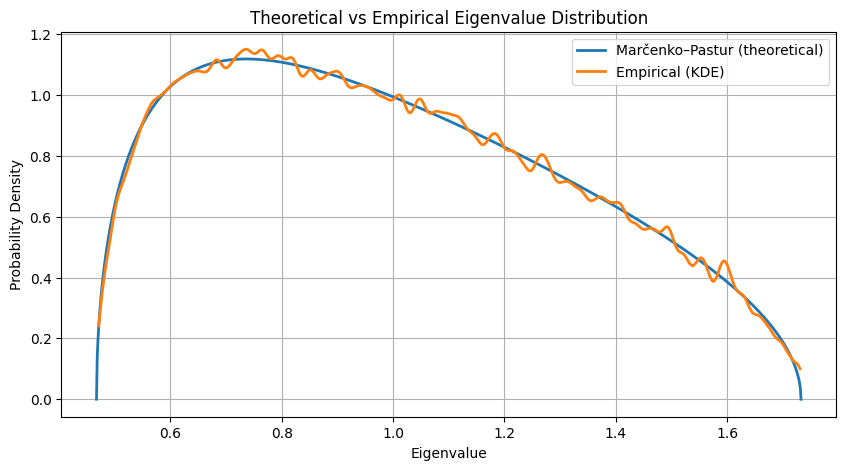

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
pdf0.plot(label='Marčenko–Pastur (theoretical)', lw=2)
pdf1.plot(label='Empirical (KDE)', lw=2)
plt.legend()
plt.xlabel('Eigenvalue')
plt.ylabel('Probability Density')
plt.title('Theoretical vs Empirical Eigenvalue Distribution')
plt.grid(True)
plt.show()


Now there is an issue.. with real data the cov matrix might be not perfectly random!

So we need to add a signal...

In [8]:
def getRndCov(nCols, nFacts):
    # Generate a random covariance matrix with specified number of factors
    w = np.random.normal(size=(nCols, nFacts))
    cov = np.dot(w, w.T)  # This is a low-rank (rank-deficient) matrix
    cov += np.diag(np.random.uniform(size=nCols))  # Add noise to make it full-rank
    return cov

def cov2corr(cov):
    # Convert a covariance matrix to a correlation matrix
    std = np.sqrt(np.diag(cov))
    corr = cov / np.outer(std, std)
    corr[corr < -1] = -1  # Clip due to numerical errors
    corr[corr > 1] = 1
    return corr

alpha = 0.995        # mixing weight: mostly empirical covariance, little signal
nCols = 1000         # number of variables (e.g., assets)
nFact = 100          # number of hidden factors (e.g., latent risk drivers)
q = 10               # T/N ratio = q => T = nCols * q

# Step 1: Create empirical covariance matrix from random data
raw_data = np.random.normal(size=(nCols * q, nCols))  # T=10,000 observations of 1,000 variables
cov_empirical = np.cov(raw_data, rowvar=False)

# Step 2: Create a structured signal covariance matrix
cov_signal = getRndCov(nCols, nFact)

# Step 3: Combine the two with alpha weighting
cov = alpha * cov_empirical + (1 - alpha) * cov_signal

# Step 4: Convert to correlation matrix
corr0 = cov2corr(cov)

# Step 5: Perform eigen decomposition
eVal0, eVec0 = getPCA(corr0)


In [10]:
from scipy.optimize import minimize

def errPDFs(var, eVal, q, bWidth, pts=1000):
    # Computes sum of squared errors (SSE) between theoretical MP PDF and KDE fit of empirical eigenvalues
    pdf0 = mpPDF(var, q, pts)                           # Theoretical MP PDF
    pdf1 = fitKDE(eVal, bWidth, x=pdf0.index.values)    # Empirical eigenvalue distribution
    sse = np.sum((pdf1 - pdf0)**2)                      # Sum of squared errors
    return sse
def findMaxEval(eVal, q, bWidth):
    # Optimize variance `var` that best fits the empirical eigenvalue distribution to MP
    out = minimize(lambda x: errPDFs(x[0], eVal, q, bWidth), x0=[0.5], bounds=[(1E-5, 1 - 1E-5)])

    if out['success']:
        var = out['x'][0]
    else:
        var = 1  # fallback

    # Compute the theoretical maximum eigenvalue (λ+)
    eMax = var * (1 + (1. / q)**0.5)**2
    return eMax, var

eMax0, var0 = findMaxEval(np.diag(eVal0), q, bWidth=0.01)

# Count number of signal eigenvalues above the noise threshold
nFacts0 = eVal0.shape[0] - np.diag(eVal0)[::-1].searchsorted(eMax0)


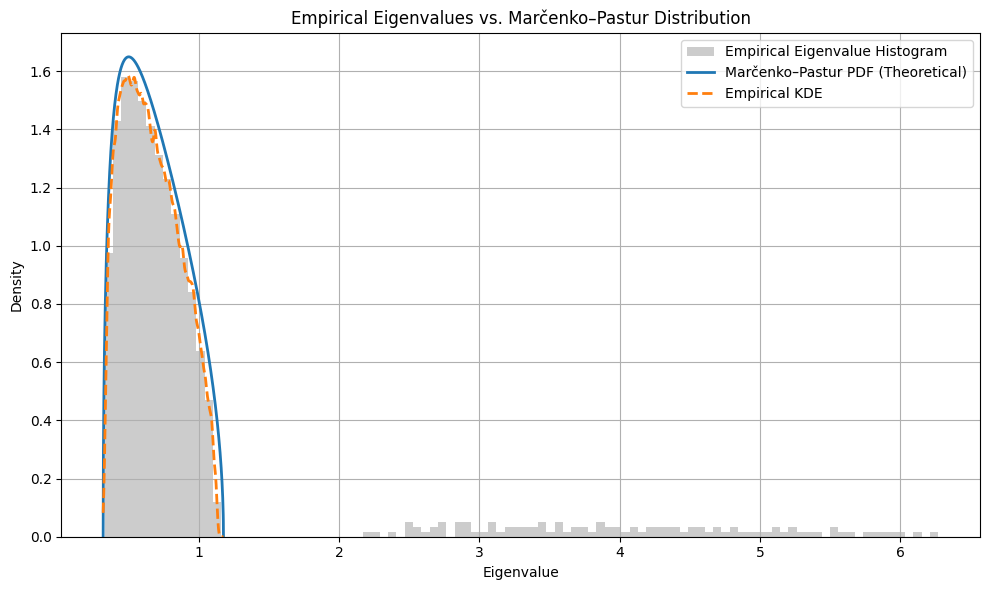

In [11]:
import matplotlib.pyplot as plt

# Flatten eigenvalues (they're in a diagonal matrix)
empirical_eVals = np.diag(eVal0)

# Fit theoretical Marčenko–Pastur PDF
pdf_mp = mpPDF(var0, q, pts=1000)

# Fit KDE to empirical eigenvalues
pdf_empirical = fitKDE(empirical_eVals, bWidth=0.01, x=pdf_mp.index.values)

# Plotting
plt.figure(figsize=(10,6))
plt.hist(empirical_eVals, bins=100, density=True, alpha=0.4, color='gray', label='Empirical Eigenvalue Histogram')
plt.plot(pdf_mp.index, pdf_mp.values, label='Marčenko–Pastur PDF (Theoretical)', linewidth=2)
plt.plot(pdf_empirical.index, pdf_empirical.values, label='Empirical KDE', linewidth=2, linestyle='--')

plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.title('Empirical Eigenvalues vs. Marčenko–Pastur Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [13]:
nFacts0, var0

(np.int64(100), np.float64(0.6782166553756225))

-  Eigenvalues to the right of the ﬁtted
Marcenko–Pastur distribution cannot be associated with noise, thus they are
related to signal.
- The ﬁtted distribution implies that σ2 ≈ :6768, indicating that only about 32.32% of the variance can be attributed to signal. This is one way of measuring
the signal-to-noise ratio in ﬁnancial data sets, which is known to be low as a result of arbitrage forces.

### Denoising

In general applications it is important to shirnk a covaraince matrix when tis is bad conditioned.

- The condition number k(A) = λ_max/λ_min
- when k(A) is too big the matrix is ill-conditioned (that is small input errors are propagated at the output)
- This creates plrobelm for example if need to invert the matrix... it might be singular due to numerial error!


So we want to make it closed to a diagonal matrix -> a diagonal cov matrix has zero cov between different assets)

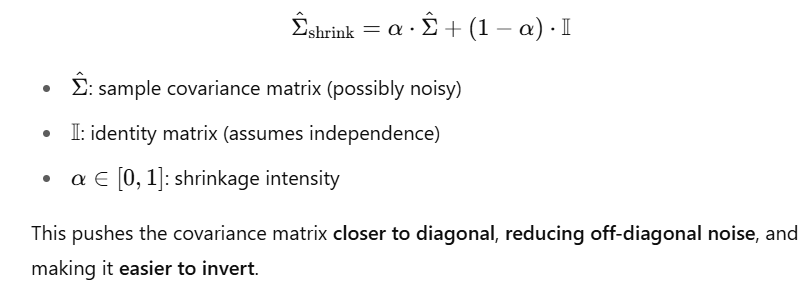

But we need to discriminate btween shrinking noise and signal... if not we can further eliminate the little signal we had at the begnining of the process :(

We can use the *Constant Residual Eigenvalue Method*

... How?

We assume that only the top few eigenvalues (and their associated eigenvectors) capture true signal (e.g., real structure in asset returns), while the rest are likely just noise. The idea is to:

Preserve the top
𝑖
i eigenvalues
𝜆1
,
…
,
𝜆
𝑖



Replace the remaining eigenvalues (associated with random eigenvectors) with a constant value

Ensure the trace is preserved (i.e., total variance remains unchanged)

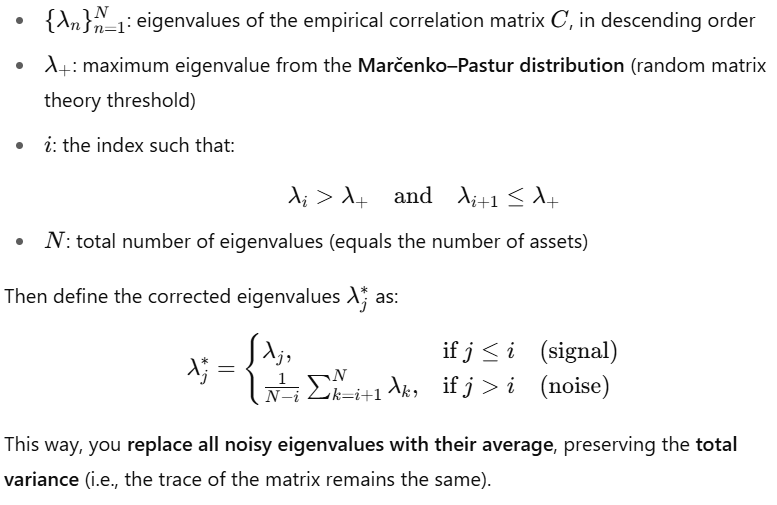

1. decompose C as C = WΛW' with W matrix of eigenvectors(cols) and Λ diag matrix of eigenvlaues
2. create a new diag matrix Λ* replacing the eigen val as explained before
3. get the denoised covar matrix Ce = WΛ*W' then normalize Ce to have diagonal 1
4. C* = diag(Ce)^-0.5 Ce diag(Ce)^-0.5

In [15]:
# DENOISING BY CONSTANT RESIDUAL EIGENVALUE

def denoisedCorr(eVal,eVec,nFacts):
#Remove noise from corr by ﬁxing random eigenvalues
  eVal_=np.diag(eVal).copy()
  eVal_[nFacts:]=eVal_[nFacts:].sum()/ﬂoat(eVal_.shape[0]-nFacts)
  eVal_=np.diag(eVal_)
  corr1=np.dot(eVec,eVal_).dot(eVec.T)
  corr1=cov2corr(corr1)
  return corr1
#---------------------------------------------------
corr1=denoisedCorr(eVal0,eVec0,nFacts0)
eVal1,eVec1=getPCA(corr1)